In [1]:
import cvxpy as cp
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

## Fixed States 

In [3]:
# state_choices = [0, 1]
# s = np.random.choice(state_choices, T)
# theta = cp.Variable((len(state_choices), n_features))
# diff = [0.5 * cp.norm2(y[i, :] - theta[s[i], :]) ** 2 for i in range(T)]
# objective = cp.Minimize(cp.sum(diff))
# prob = cp.Problem(objective)
# prob.solve()

In [407]:
T = 100
n_features = 2
state_choices = [0, 1]

np.random.seed(42)
y = np.random.randint(0, 100, (T, n_features))
s = np.random.choice([0, 1], T)

In [3]:
def fixedStatesOptimize(y, s, theta_guess=None, state_choices=[0, 1]):
    if not isinstance(y, np.ndarray) or not isinstance(s, np.ndarray):
        raise TypeError("y and s must be numpy arrays")
    T, n_features = y.shape
    # initialize variables from guess
    theta = cp.Variable((len(state_choices), n_features))
    if theta_guess is not None:
        theta.value = theta_guess
    
    # solve optimization problem
    diff = [0.5 * cp.norm2(y[i, :] - theta[s[i], :]) ** 2 for i in range(T)]
    objective = cp.Minimize(cp.sum(diff))
    prob = cp.Problem(objective)
    prob.solve()
    return theta.value, prob.value

In [342]:
theta, loss = fixedStatesOptimize(y, s)

Remember that $\theta$ is simply the parameters of the states, which in simplest case is just the means of the features, since we set the loss function as the K-means loss function. We could check that the best estimate for $\theta$ is the mean of the features assuming fixed states. 

In [343]:
print(theta, "\n", loss)

[[49.64582822 52.02084104]
 [44.69230438 49.96153378]] 
 86840.47916666954


In [344]:
y[s == 1].mean(axis=0)

array([44.69230769, 49.96153846])

In [345]:
print(s)

[0 1 0 0 0 1 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 1 1 0 1 0 0 0 0 1 0 0 0 1 1 1 1
 0 0 1 0 0 0 1 1 0 1 1 1 1 1 0 1 0 0 1 0 0 0 1 1 0 1 1 1 1 0 0 1 1 0 0 1 0
 1 1 0 0 1 1 0 1 0 1 0 0 0 1 1 0 1 0 0 1 1 0 1 1 0 0]


## Fixed Theta: Solve States by DP Algorithm

In [4]:
def generateLossMatrix(y, theta, state_choices=[0, 1]):
    T, n_features = y.shape
    loss = np.zeros((T, len(state_choices)))
    for i in range(T):
        for j in range(len(state_choices)):
            # norm is the L2 norm by default
            loss[i, j] = 0.5 * np.linalg.norm(y[i, :] - theta[j, :]) ** 2
    return loss

In [68]:
lossMatrix = generateLossMatrix(y, theta)

In [170]:
lambda_ = 1e2
V = np.zeros((T, len(state_choices)))
V[0, :] = lossMatrix[0, :]
for t in range(1, T):
    for k in range(len(state_choices)):
        V[t, k] = lossMatrix[t, k] + min(V[t - 1, :] + lambda_ * np.abs(state_choices[k] - np.array(state_choices)))

v = V[-1, :].min()
s[-1] = state_choices[V[-1, :].argmin()]

for t in range(T - 2, -1, -1):
    s[t] = state_choices[np.argmin(V[t, :] + lambda_ * np.abs(state_choices - s[t + 1]))]

print(s, "\n", v)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] 
 5323.190000011761


In [5]:
def fixedThetaOptimize(lossMatrix, lambda_, state_choices=[0, 1]):
    T, n_states = lossMatrix.shape
    V = np.zeros((T, n_states))
    V[0, :] = lossMatrix[0, :]
    for t in range(1, T):
        for k in range(n_states):
            V[t, k] = lossMatrix[t, k] + min(V[t - 1, :] + lambda_ * np.abs(state_choices[k] - np.array(state_choices)))
    v = V[-1, :].min()
    s = np.zeros(T, dtype=int)
    s[-1] = state_choices[V[-1, :].argmin()]
    for t in range(T - 2, -1, -1):
        s[t] = state_choices[np.argmin(V[t, :] + lambda_ * np.abs(state_choices - s[t + 1]))]
    return s, v

In [71]:
fixedThetaOptimize(lossMatrix, lambda_=1e2)

(array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1]),
 83808.00603733146)

## Convergence

In [408]:
np.random.seed(42)
y = np.vstack((np.random.randint(0, 10, (int(T/4), n_features)),
               np.random.randint(5, 25, (int(T/4), n_features)),
               np.random.randint(0, 10, (int(T/4), n_features)),
               np.random.randint(5, 25, (int(T/4), n_features))))
true_s = np.hstack((np.random.choice([0], int(T/4)),
                    np.random.choice([1], int(T/4)),
                    np.random.choice([0], int(T/4)),
                    np.random.choice([1], int(T/4))))

In [415]:
optimized_s = list()
optimized_loss = list()

# try differnt initializations
for trial in tqdm(range(10)):
    np.random.seed()
    cur_s = np.random.choice([0, 1], T)
    cur_theta = np.random.randint(0, 15, (len(state_choices), n_features))
    hist_s = [cur_s]

    # maximize number of iterations
    for i in range(100):
        cur_theta, _ = fixedStatesOptimize(y, cur_s, theta_guess=cur_theta)
        lossMatrix = generateLossMatrix(y, cur_theta)
        cur_s, loss = fixedThetaOptimize(lossMatrix, lambda_=10)
        if cur_s.tolist() == hist_s[-1].tolist() == hist_s[-2].tolist():
            print("Converged after {} iterations".format(i))
            print("Best loss: {}".format(loss))
            break
        else:
            hist_s.append(cur_s)

    optimized_s.append(cur_s)
    optimized_loss.append(loss)

 10%|█         | 1/10 [00:01<00:17,  1.91s/it]

Converged after 4 iterations
Best loss: 1836.0090312250932


 20%|██        | 2/10 [00:03<00:14,  1.83s/it]

Converged after 4 iterations
Best loss: 1835.6580987496072


 30%|███       | 3/10 [00:05<00:12,  1.78s/it]

Converged after 4 iterations
Best loss: 1835.6580987496072


 40%|████      | 4/10 [00:07<00:10,  1.82s/it]

Converged after 4 iterations
Best loss: 1835.6580987496072


 50%|█████     | 5/10 [00:09<00:09,  1.81s/it]

Converged after 4 iterations
Best loss: 1835.6580987496072


 60%|██████    | 6/10 [00:10<00:07,  1.77s/it]

Converged after 4 iterations
Best loss: 1835.6580987496072


 70%|███████   | 7/10 [00:12<00:05,  1.78s/it]

Converged after 4 iterations
Best loss: 1835.6580987496072


 80%|████████  | 8/10 [00:14<00:03,  1.78s/it]

Converged after 4 iterations
Best loss: 1835.6580987496072


 90%|█████████ | 9/10 [00:16<00:01,  1.76s/it]

Converged after 4 iterations
Best loss: 1835.6580987496072


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]

Converged after 4 iterations
Best loss: 1835.6580987496072


In [416]:
best_s = optimized_s[np.array(optimized_loss).argmin()]
best_loss = np.array(optimized_loss).min()

In [417]:
optimized_loss

[1836.0090312250932,
 1835.6580987496072,
 1835.6580987496072,
 1835.6580987496072,
 1835.6580987496072,
 1835.6580987496072,
 1835.6580987496072,
 1835.6580987496072,
 1835.6580987496072,
 1835.6580987496072]

In [418]:
(best_s == true_s).sum() / T

0.93

In [419]:
best_s

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1])

# Simulation Studies

## Generate Feature Data

In [6]:
from sklearn import preprocessing

def compute_features(time_series):
    df = pd.DataFrame({'ts': time_series})
    
    # Features 1-3
    df['observation'] = df['ts']
    df['abs_change'] = df['ts'].diff().abs()
    df['prev_abs_change'] = df['abs_change'].shift()

    # Features 4-9 for w=6 and w=14
    for w in [6, 14]:
        roll = df['ts'].rolling(window=w)
        df[f'centered_mean_{w}'] = roll.mean()
        df[f'centered_std_{w}'] = roll.std()

        half_w = w // 2
        df[f'left_mean_{w}'] = df['ts'].rolling(window=half_w).mean().shift(half_w)
        df[f'left_std_{w}'] = df['ts'].rolling(window=half_w).std().shift(half_w)
        
        df[f'right_mean_{w}'] = df['ts'].rolling(window=half_w).mean()
        df[f'right_std_{w}'] = df['ts'].rolling(window=half_w).std()

    # Drop the original time series column
    df = df.drop(columns=['ts'])

    return df.values


def standarize_features(X):
    return preprocessing.StandardScaler().fit_transform(X)    

## Simulate Returns

In [29]:
from scipy.linalg import fractional_matrix_power
i = np.array([[.9629, .0371], [.2102, .7899]])
fractional_matrix_power(i, 1/20)

array([[0.99788413, 0.00211576],
       [0.01198743, 0.98801817]])

In [9]:
import numpy as np

def stationary_distribution(transition_matrix):
    """
    Computes the stationary distribution for a given Markov transition matrix.
    
    Parameters:
    - transition_matrix (numpy array): The Markov transition matrix.

    Returns:
    - numpy array: The stationary distribution.
    """
    size = len(transition_matrix)
    # Create a matrix subtracted from the identity matrix
    Q = np.eye(size) - transition_matrix.T
    # Append a ones row to handle the constraint sum(pi) = 1
    Q = np.vstack([Q, np.ones(size)])
    # Create the target matrix (last entry is 1 for the sum(pi) = 1 constraint)
    b = np.zeros(size + 1)
    b[-1] = 1
    # Solve the linear system
    pi = np.linalg.lstsq(Q, b, rcond=None)[0]
    return pi

def simulate_markov(transition_matrix, initial_distribution, steps):
    """
    Simulates a Markov process.
    
    Parameters:
    - transition_matrix (numpy array): The Markov transition matrix.
    - initial_distribution (numpy array): The initial state distribution.
    - steps (int): The number of steps to simulate.

    Returns:
    - list: The states at each step.
    """
    state = np.random.choice(len(initial_distribution), p=initial_distribution)
    states = [state]
    
    for _ in range(steps):
        state = np.random.choice(len(transition_matrix[state]), p=transition_matrix[state])
        states.append(state)
    
    return states

def generate_conditional_data(states, parameters):
    """
    Generates data based on the states and provided parameters.
    
    Parameters:
    - states (list): The list of states.
    - parameters (dict): Parameters for each state with means and standard deviations.

    Returns:
    - list: Simulated data conditional on the states.
    """
    data = []
    for state in states:
        mu, sigma = parameters[state]
        value = np.random.normal(mu, sigma)
        data.append(value)
    return data

In [10]:
# Example usage:
transition_matrix = np.array([
    [0.99788413, 0.00211587],  # From state 0 to states 0 and 1
    [0.01198743, 0.98801257]   # From state 1 to states 0 and 1
])

initial_distribution = stationary_distribution(transition_matrix)
steps = 1000

simulated_states = simulate_markov(transition_matrix, initial_distribution, steps)
simulated_data = generate_conditional_data(simulated_states, parameters)

# Assuming state 0 corresponds to mu1, sigma1 and state 1 to mu2, sigma2
parameters = {
    0: (0.000615, 0.007759155881924271),  # mu1, sigma1
    1: (-0.000785, 0.017396608864948364) # mu2, sigma2
}

simulated_data = generate_conditional_data(simulated_states, parameters)

In [11]:
sum(simulated_states)

393

In [12]:
feature_data = compute_features(simulated_data)

In [13]:
y = feature_data[~np.isnan(feature_data).any(axis=1)]
y = standarize_features(y)

## K-means ++

In [14]:
import numpy as np

def initialize_kmeans_plusplus(data, k):
    """
    Initialize the centroids using the k-means++ method.
    
    Parameters:
    - data: ndarray of shape (n_samples, n_features)
    - k: number of clusters
    
    Returns:
    - centroids: ndarray of shape (k, n_features)
    """
    initial_idx = np.random.choice(data.shape[0], 1)
    centroids = [data[initial_idx]]
    
    for _ in range(k - 1):
        squared_distances = np.min([np.sum((data - centroid)**2, axis=1) for centroid in centroids], axis=0)
        prob = squared_distances / squared_distances.sum()
        next_centroid_idx = np.random.choice(data.shape[0], 1, p=prob)
        centroids.append(data[next_centroid_idx])
    
    return np.array(centroids)

def classify_data_to_states(data, centroids):
    """
    Classify data points to the states based on the closest centroid.
    
    Parameters:
    - data: ndarray of shape (n_samples, n_features)
    - centroids: centroids or means of the states, ndarray of shape (k, n_features)
    
    Returns:
    - state_assignments: ndarray of shape (n_samples,), indices of the states to which each data point is assigned
    """
    distances = np.array([np.sum((data - centroid)**2, axis=1) for centroid in centroids])
    state_assignments = np.argmin(distances, axis=0)
    return state_assignments

# Example usage:
data = np.array([[1, 2], [5, 8], [1.5, 1.8], [8, 8], [1, 0.6], [9, 11]])
k = 2
centroids = initialize_kmeans_plusplus(data, k)
state_assignments = classify_data_to_states(data, centroids)
print(state_assignments)


[1 0 1 0 1 0]


In [15]:
data

array([[ 1. ,  2. ],
       [ 5. ,  8. ],
       [ 1.5,  1.8],
       [ 8. ,  8. ],
       [ 1. ,  0.6],
       [ 9. , 11. ]])

## Perform Optimization

In [ ]:
optimized_s = list()
optimized_loss = list()

T = y.shape[0]
# try differnt initializations
for trial in tqdm(range(10)):
    centroids = initialize_kmeans_plusplus(y, 2)
    cur_s = classify_data_to_states(y, centroids)
    cur_theta = np.random.randn(2, 15)
    hist_s = [cur_s]

    # maximize number of iterations
    for i in range(100):
        cur_theta, _ = fixedStatesOptimize(y, cur_s, theta_guess=None)
        lossMatrix = generateLossMatrix(y, cur_theta)
        cur_s, loss = fixedThetaOptimize(lossMatrix, lambda_=100)
        if cur_s.tolist() == hist_s[-1].tolist():
            print("Converged after {} iterations".format(i))
            print("Best loss: {}".format(loss))
            break
        else:
            hist_s.append(cur_s)

    optimized_s.append(cur_s)
    optimized_loss.append(loss)

  0%|          | 0/10 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.10/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_vars.py", line 624, in change_attr_expression
    value = eval(expression, frame.f_globals, frame.f_locals)
  File "<string>", line 1, in <module>
NameError: name 'array' is not defined


Converged after 2 iterations
Best loss: 5700.968244035476


 20%|██        | 2/10 [03:32<12:03, 90.46s/it] 

Converged after 1 iterations
Best loss: 5700.968244035476


 30%|███       | 3/10 [03:56<06:59, 59.94s/it]

Converged after 2 iterations
Best loss: 5700.968244035476


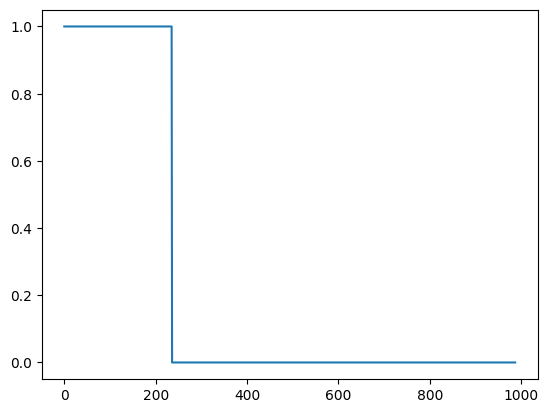

In [55]:
plt.plot(optimized_s[9])

In [31]:
best_s = optimized_s[np.array(optimized_loss).argmin()]

In [32]:
sum(best_s == np.array(simulated_states)[13:]) / len(best_s)

0.0020242914979757085

In [33]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(best_s, np.array(simulated_states)[13:])

0.00423728813559322

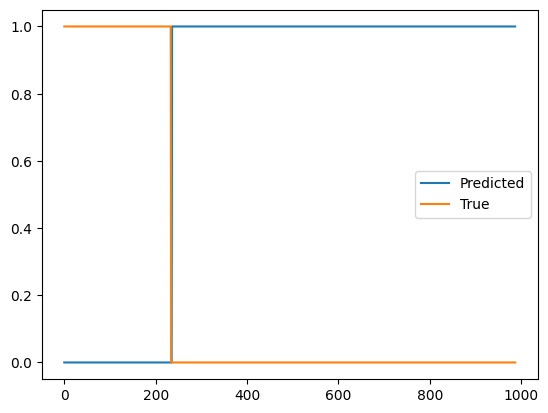

In [52]:
plt.plot(best_s, label="Predicted")
plt.plot(np.array(simulated_states)[13:], label="True")
plt.legend()

## Multiprocessing

In [16]:
import multiprocessing as mp

def run_trial(n):
    centroids = initialize_kmeans_plusplus(y, 2)
    cur_s = classify_data_to_states(y, centroids)
    hist_s = [cur_s]

    # maximize number of iterations
    for i in range(100):
        cur_theta, _ = fixedStatesOptimize(y, cur_s, theta_guess=None)
        lossMatrix = generateLossMatrix(y, cur_theta)
        cur_s, loss = fixedThetaOptimize(lossMatrix, lambda_=100)
        if cur_s.tolist() == hist_s[-1].tolist():
            print("Converged after {} iterations".format(i))
            print("Best loss: {}".format(loss))
            break
        else:
            hist_s.append(cur_s)

    return cur_s, loss, cur_theta

pool = mp.Pool(mp.cpu_count())
results = pool.map(run_trial, range(10))

Converged after 2 iterations
Best loss: 7039.593054413656
Converged after 2 iterations
Best loss: 7039.593054413656
Converged after 2 iterations
Best loss: 7039.593054413656
Converged after 2 iterations
Best loss: 7039.593054413656
Converged after 2 iterations
Best loss: 7039.593054413656
Converged after 2 iterations
Best loss: 7039.593054413656
Converged after 2 iterations
Best loss: 7039.593054413656
Converged after 2 iterations
Best loss: 7039.593054413656
Converged after 3 iterations
Best loss: 6108.224741306374
Converged after 3 iterations
Best loss: 6108.224741306374


In [17]:
def remapResults(optimized_s, optimized_theta):
    res_s = list()
    res_theta = list()
    n = len(optimized_s)
    for i in range(n):
        idx = np.argsort(optimized_theta[i][:, 0])[::-1]
        idx_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(idx)}
        remapped_s = [idx_mapping[i] for i in optimized_s[i]]
        remapped_theta = optimized_theta[i][idx, :]
        res_s.append(remapped_s)
        res_theta.append(remapped_theta)

    return res_s, res_theta

In [18]:
optimized_s = [result[0] for result in results]
optimized_loss = [result[1] for result in results]
optimized_theta = [result[2] for result in results]
optimized_s, optimized_theta = remapResults(optimized_s, optimized_theta)
best_s = optimized_s[np.array(optimized_loss).argmin()]
best_loss = np.array(optimized_loss).min()

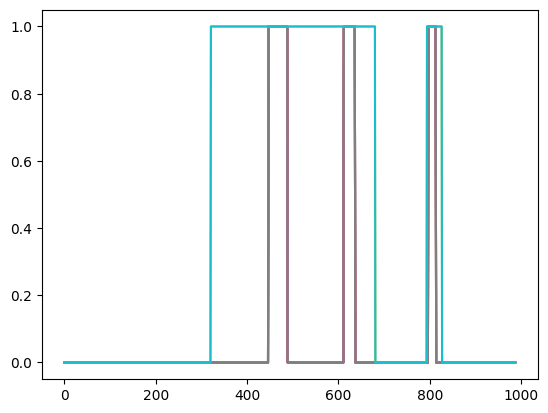

In [19]:
for i in range(10):
    plt.plot(optimized_s[i], label="Trial {}".format(i))

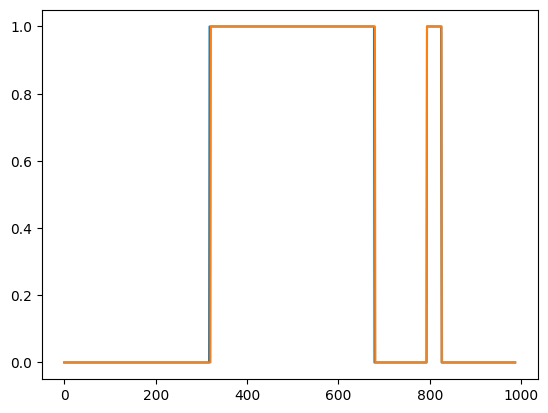

In [21]:
plt.plot(np.array(simulated_states)[13:], label="True")
plt.plot(best_s, label="Predicted")

# Appendix

## Loss Function

In [102]:
def jumpModelLoss(y, theta, s, lambda_):
    T = y.shape[0]
    loss = 0
    for i in range(T):
        loss += 0.5 * np.linalg.norm(y[i, :] - theta[s[i], :]) ** 2

    # add the jump penalty
    x = np.array(s)
    loss += np.sum((x[:-1] - x[1:]) != 0) * lambda_
    return loss

In [145]:
jumpModelLoss(y, optimized_theta[4], optimized_s[4], lambda_=1e2)

5700.968244035476

In [178]:
optimized_theta[4]

array([[-0.12904715,  0.71171551,  0.71982611, -0.34791984,  1.3237084 ,
        -0.26075333,  0.95722171, -0.21958871,  0.95010333, -0.64367765,
         1.55099418, -0.47177916,  1.3159229 , -0.38334635,  1.37762253],
       [ 0.04049715, -0.22336956, -0.22591031,  0.10918379, -0.41543977,
         0.08183025, -0.30040789,  0.06891011, -0.29818434,  0.20199707,
        -0.48677056,  0.14805123, -0.41298299,  0.12030183, -0.43236072]])

In [177]:
optimized_theta[0]

array([[ 0.04049715, -0.22336956, -0.22591031,  0.10918379, -0.41543977,
         0.08183025, -0.30040789,  0.06891011, -0.29818434,  0.20199707,
        -0.48677056,  0.14805123, -0.41298299,  0.12030183, -0.43236072],
       [-0.12904715,  0.71171551,  0.71982611, -0.34791984,  1.3237084 ,
        -0.26075333,  0.95722171, -0.21958871,  0.95010333, -0.64367765,
         1.55099418, -0.47177916,  1.3159229 , -0.38334635,  1.37762253]])

In [149]:
optimized_s[4]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [117]:
optimized_s[2]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [112]:
cur_s

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Fixed Parameters

In [33]:
# state_choices = [0, 1]
# T = 10
# n_features = 2
# y = np.random.randint(0, 100, (T, n_features))
# theta = np.random.randint(0, 100, (len(state_choices), n_features))


# # s is the target state sequence we want to optimize
# # b = cp.Variable((T, len(state_choices)), boolean=True)
# # s = [cp.sum(b[i, :]) for i in range(T)]
# # constraints = [cp.sum(b[i, :]) == 1 for i in range(T)]
# s = cp.Variable(T, integer=True)

# constraints = [s[i] >= 0 for i in range(T)]
# constraints += [s[i] <= len(state_choices) - 1 for i in range(T)]

# # penalty for switching states
# lambda_ = cp.Parameter(nonneg=True)
# lambda_.value = 1
# loss = cp.sum([0.5 * cp.norm2(y[i, :] - theta[s[i], :]) ** 2 for i in range(T)])
# num_diff = cp.sum([cp.abs(s[i] - s[i + 1]) for i in range(T - 1)])
# state_swith_penalty = lambda_ * num_diff

# objective = cp.Minimize(loss + state_swith_penalty)
# prob = cp.Problem(objective, constraints)
# prob.solve()